# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [97]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import re

In [98]:
# load user-item-interactions.csv and articles_community.csv datasets
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')

del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [99]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [100]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [101]:
# check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [102]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [103]:
# converting article id to the same format in both datasets

df['article_id'] = df['article_id'].astype(str)
df_content['article_id'] = df_content['article_id'].\
    astype('float64').astype(str)

In [104]:
# emails are interactions. The articles with the most interactions are the most popular. 
# These are then the articles we might recommend to new users.

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [105]:
df_users_articles = df.groupby('email').size().\
    reset_index(name='count_interactions')

In [106]:
df_users_articles.describe()

,count_interactions
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


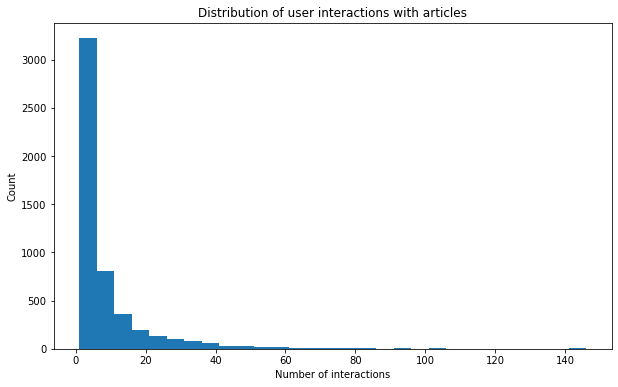

In [107]:
plt.figure(figsize=[10, 6])
bin_edges = np.arange(1, 150, 5)
plt.hist(data=df_users_articles, x='count_interactions', bins=bin_edges)
plt.xlabel("Number of interactions")
plt.ylabel('Count')
plt.title("Distribution of user interactions with articles")
plt.show()

In [108]:
# the distribution is highly right skewed, most of the users have only 1 interaction with article. 
# the user has on average around 9 interactions with articles.

In [109]:
# Fill in the median and maximum number of user_article interactios below

median_val = df_users_articles['count_interactions'].median()
print(median_val)
max_views_by_user = df_users_articles['count_interactions'].max()
print(max_views_by_user)

3.0
364


In [110]:
df_user_counts = df.groupby('article_id').size().\
    reset_index(name='count_users')

In [111]:
df_user_counts.describe()

,count_users
count,714.000000
mean,64.415966
std,109.175923
min,1.000000
25%,8.000000
50%,25.000000
75%,69.000000
max,937.000000


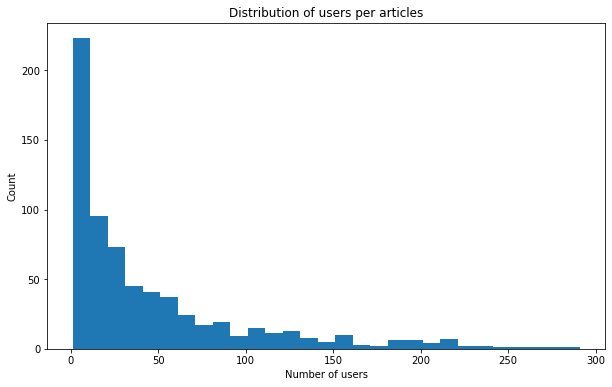

In [112]:
plt.figure(figsize=[10, 6])
bin_edges = np.arange(1, 300, 10)
plt.hist(data=df_user_counts, x='count_users', bins=bin_edges)
plt.xlabel("Number of users")
plt.ylabel('Count')
plt.title("Distribution of users per articles")
plt.show()

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [113]:
# Find and explore duplicate articles
df_content[df_content.duplicated(subset=['article_id'])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50.0
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221.0
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398.0
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577.0
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232.0


In [114]:
df_content.shape

(1056, 5)

In [115]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'], keep='first')

In [116]:
# check that only 5 duplicates are deleted
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [117]:
unique_articles = df_user_counts.article_id.nunique()
print(f'Articles with at least one interaction: {unique_articles}')

total_articles = df_content.article_id.nunique()
print(f'The number of unique articles on the IBM platform: {total_articles}')

unique_users = df.email.nunique()
print(f'The number of unique users: {unique_users}')

user_article_interactions = len(df)
print(f'The number of user-article interactions: {user_article_interactions}')

Articles with at least one interaction: 714
The number of unique articles on the IBM platform: 1051
The number of unique users: 5148
The number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [118]:
df_user_counts.head()

,article_id,count_users
0,0.0,14
1,100.0,9
2,1000.0,16
3,1004.0,7
4,1006.0,14


In [119]:
# find which article is the most viewed
df_user_counts[df_user_counts['count_users'] ==
               df_user_counts['count_users'].max()]

,article_id,count_users
311,1429.0,937


In [120]:
# Get the most viewed article in the dataset
most_viewed_article_id = \
    df_user_counts.loc[df_user_counts['count_users'] ==
                       df_user_counts['count_users'].max(),
                       'article_id'].item()
# The most viewed article in the dataset was viewed how many times?
max_views = df_user_counts['count_users'].max()
print(f'Article {most_viewed_article_id} was viewed {max_views} times')

Article 1429.0 was viewed 937 times


In [121]:
# Mapping of the user email to a user_id column

def email_mapper():
    '''
    This function maps the user email to a user_id

    '''
    coded_dict = dict()
    cter = 1
    email_encoded = []
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter += 1
        email_encoded.append(coded_dict[val])
    return email_encoded


email_encoded = email_mapper()

del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [122]:
# If you stored all your results in the variable names above, 
# you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [123]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles
    '''
    # count of user per article
    user_count = df.groupby(['article_id', 'title']).size().\
        reset_index(name='count_users')
    # sort the articles by popularity
    top_articles = (user_count.sort_values('count_users',
                                           ascending=False)
                    ['title'][:n].tolist())
    # Return the top article titles from df (not df_content)
    return top_articles


def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles
    
    '''
    # Your code here
    user_count = df.groupby('article_id')['user_id'].count().\
        reset_index(name='count_users')
    top_articles = (user_count.sort_values(['count_users'],
                                           ascending=False)['article_id']
                    [:n].tolist())
    # Return the top article ids
    return top_articles

In [124]:
get_top_articles(5)

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm']

In [125]:
get_top_article_ids(5)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0']

In [126]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [127]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns

    OUTPUT:
    user_item - user item matrix

    Description:
    Return a matrix with user ids as rows and article ids on the columns
    with 1 values where a user interacted with
    an article and a 0 otherwise

    '''
    # Fill in the function here
    user_item = df.copy()
    user_item = user_item.drop_duplicates()
    user_item = pd.crosstab(index=user_item.user_id,
                            columns=user_item.article_id)
    # return the user_item matrix
    return user_item


user_item = create_user_item_matrix(df)

In [128]:
user_item.shape

(5149, 714)

In [129]:
user_item.sum(axis=1)[1]

36

In [130]:
# Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [131]:
user_item.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    similar_users - (list) an ordered list where the closest users
                    (largest dot product users)
                    are listed first

    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of similar users

    '''
    user = user_item.loc[user_id]
    # compute similarity of each user to the provided user
    dot_prod_users = user_item.dot(np.transpose(user))
    # sort by similarity
    dot_prod_users_sorted = dot_prod_users.sort_values(ascending=False)
    # create list of just the ids
    most_similar_users = dot_prod_users_sorted.index.values.tolist()
    # remove the own user's id
    most_similar_users.remove(user_id)
    # return a list of the users in order from most to least similar
    return most_similar_users

In [133]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


In [134]:
def get_articles_read(user_id):
    '''
    INPUT:
    user_id - the user_id of an individual as int

    OUTPUT:
    articles - an array of articles the user has read

    '''
    articles = user_item.loc[user_id][user_item.loc[user_id] == 1].index.values

    return articles

In [135]:
get_articles_read(3)

array(['1035.0', '1057.0', '1059.0', '109.0', '116.0', '1165.0', '1172.0',
       '1192.0', '12.0', '120.0', '1225.0', '1271.0', '1293.0', '1314.0',
       '1330.0', '1343.0', '1351.0', '1360.0', '1397.0', '1429.0',
       '1431.0', '1432.0', '1436.0', '193.0', '20.0', '213.0', '29.0',
       '381.0', '43.0', '50.0', '62.0', '681.0', '720.0', '721.0',
       '735.0', '784.0', '788.0', '868.0', '957.0', '977.0'], dtype=object)

In [136]:
# create a dictionary: keys = users, values = articles read
def create_user_article_dict():
    '''
    INPUT: None

    OUTPUT:
    articles_read - a dictionary where each key is a user_id and
    the value is an array of article_ids the user has read

    '''
    n_users = user_item.shape[0]
    articles_read = dict()

    for user1 in range(1, n_users+1):
        # assign list of articles to each user key
        articles_read[user1] = get_articles_read(user1)

    return articles_read


articles_read = create_user_article_dict()

In [137]:
# Remove individuals who have read 2 or fewer articles -
# don't have enough data to make recs

def create_articles_to_analyze(articles_read, lower_bound=2):
    '''
    INPUT:
    articles_read - a dictionary where each key is a user_id and
                    the value is an array of article_ids
    lower_bound - (an int) a user must have more articles read than
                    the lower bound to be added to the
                    articles_to_analyze dictionary

    OUTPUT:
    articles_to_analyze - a dictionary where each key is a user_id and
        the value is an array of article_ids

    description:
    The articles_read and articles_to_analyze dictionaries
    should be the same except that the output dictionary has removed

    '''
    articles_to_analyze = dict()

    for user, articles in articles_read.items():
        if len(articles) > lower_bound:
            articles_to_analyze[user] = articles
    return articles_to_analyze


articles_to_analyze = create_articles_to_analyze(articles_read)

In [138]:
# check articles to analyze for user 46.
articles_to_analyze[46]

array(['1014.0', '1017.0', '1054.0', '109.0', '1162.0', '1164.0',
       '1170.0', '1185.0', '1192.0', '1293.0', '1305.0', '1351.0',
       '1360.0', '1364.0', '1368.0', '1393.0', '1423.0', '1427.0',
       '1429.0', '1430.0', '1436.0', '1439.0', '184.0', '2.0', '224.0',
       '295.0', '316.0', '336.0', '351.0', '43.0', '525.0', '569.0',
       '692.0', '705.0', '76.0', '868.0', '89.0', '933.0', '962.0',
       '967.0'], dtype=object)

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [139]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    article_names - (list) a list of article names associated with
    the list of article ids (this is identified by the title column)
    '''
    article_names = list(set(df[df['article_id'].isin(article_ids)]['title']))
    # Return the article names associated with list of article ids
    return article_names


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with
    the list of article ids (this is identified by the doc_full_name
    column in df_content)

    Description:
    Provides a list of the article_ids and article titles that
    have been seen by a user
    '''
    # Your code here
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].\
        index.values.tolist()
    article_names = get_article_names(article_ids)
    # return the ids and names
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before
    and provides them as recs
    Does this until m recommendations are found

    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user

    For the user where the number of recommended articles starts below
    and ends exceeding m, the last items are chosen arbitrarily

    '''
    
    # articles_read by user (we don't want to recommend these)
    articles_read = get_user_articles(user_id)[0]
    similar_users = find_similar_users(user_id)

    recs = []
    for user in similar_users:
        # get article read by similar user
        neigbh_articles = get_user_articles(user)[0]

        # Obtain recommendations for each neighbor.
        # Get articles read by neighbor user which user_id hasn't read
        new_recs = np.setdiff1d(neigbh_articles,
                                articles_read,
                                assume_unique=True)

        # Update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))

        # If we have enough recommendations exit the loop
        if len(recs) > m-1:
            break
    # return your recommendations for this user_id
    return recs[:m]

In [140]:
# Return 10 recommendations for user 1
user_user_recs(1, m=10)

array(['1000.0', '1014.0', '1025.0', '1051.0', '108.0', '1101.0',
       '1148.0', '1159.0', '1160.0', '1162.0'], dtype='<U32')

In [141]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [142]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook
    user_item - (pandas dataframe) matrix of users by articles:
            1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user
                        to the provided user_id
                    num_interactions - the number of articles
                        viewed by the user

    Other Details - sort the neighbors_df by the similarity and
        then by number of interactions where
        highest of each is higher in the dataframe

    '''
    # get the record for user_id
    user = user_item.loc[user_id]
    # compute similarity of each user to the provided user
    dot_prod_users = user_item.dot(np.transpose(user))

    neighb_similarity = dot_prod_users.to_frame('similarity').reset_index()

    neighb_interactions = df.groupby('user_id').size().\
        reset_index(name='num_interactions')

    neighbors_df = pd.merge(neighb_similarity,
                            neighb_interactions,
                            on='user_id',
                            how='left')

    neighbors_df = neighbors_df[neighbors_df['user_id'] != user_id]

    neighbors_df.sort_values(by=['similarity', 'num_interactions'],
                             ascending=False,
                             inplace=True)
    # Return the dataframe specified in the doc_string
    return neighbors_df

In [143]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook
    user_item - (pandas dataframe) matrix of users by articles:
            1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user
                        to the provided user_id
                    num_interactions - the number of articles
                        viewed by the user

    Other Details - sort the neighbors_df by the similarity and
        then by number of interactions where
        highest of each is higher in the dataframe

    '''
    # get the record for user_id
    user = user_item.loc[user_id]
    # compute similarity of each user to the provided user
    dot_prod_users = user_item.dot(np.transpose(user))

    neighb_similarity = dot_prod_users.to_frame('similarity').reset_index()

    neighb_interactions = df.groupby('user_id').size().\
        reset_index(name='num_interactions')

    neighbors_df = pd.merge(neighb_similarity,
                            neighb_interactions,
                            on='user_id',
                            how='left')

    neighbors_df = neighbors_df[neighbors_df['user_id'] != user_id]

    neighbors_df.sort_values(by=['similarity', 'num_interactions'],
                             ascending=False,
                             inplace=True)
    # Return the dataframe specified in the doc_string
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before
    and provides them as recs.
    Does this until m recommendations are found

    Notes:
    * Choose the users that have the most total article interactions
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions
    before choosing those with fewer total interactions.

    '''
    # Your code here
    similar_users = get_top_sorted_users(user_id,
                                         df=df,
                                         user_item=user_item)['user_id'].\
        tolist()
    articles_read = get_user_articles(user_id)[0]

    recs = []
    for user in similar_users:
        neigbh_articles = get_user_articles(user)[0]
        
        new_recs = np.setdiff1d(neigbh_articles,
                                articles_read,
                                assume_unique=True)
        
        top_articles = get_top_article_ids(m, df=df[df['article_id'].isin(new_recs)])
        
        recs = np.unique(np.concatenate([top_articles, recs], axis=0))

        # If we have enough recommendations exit the loop
        if len(recs) > m-1:
            break

    recs = recs[:m]
    rec_names = get_article_names(recs)
    return recs, rec_names

In [144]:
# Return 10 recommendations for user 1 by user similarity
user_user_recs(1, m=10)

array(['1000.0', '1014.0', '1025.0', '1051.0', '108.0', '1101.0',
       '1148.0', '1159.0', '1160.0', '1162.0'], dtype='<U32')

In [145]:
# Return 10 recommendations for user 1 by user similarity and top articles
rec_ids, rec_names = user_user_recs_part2(1, 10)
print(f"The top 10 recommendations for user 20: {rec_ids}")

print(f"The top 10 recommendations for user 20:{rec_names}")

The top 10 recommendations for user 20: ['1160.0' '1162.0' '1304.0' '1314.0' '1330.0' '1338.0' '1351.0' '1354.0'
 '1364.0' '1393.0']
The top 10 recommendations for user 20:['movie recommender system with spark machine learning', 'analyze accident reports on amazon emr spark', 'healthcare python streaming application demo', 'the nurse assignment problem', 'model bike sharing data with spss', 'analyze energy consumption in buildings', 'insights from new york car accident reports', 'predicting churn with the spss random tree algorithm', 'gosales transactions for logistic regression model', 'ml optimization using cognitive assistant']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [146]:
# Tests with a dictionary of results
# Find the user that is most similar to user 1
user1_most_sim = get_top_sorted_users(1).iloc[0].user_id
# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).iloc[9].user_id

In [147]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim,
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

In case of a new user we can use the rank based recommendation get_top_article_ids() because it gives the recommendation based on articles popularity in general. It doesn't take into account users past interactions with articles. 

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [148]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to
new_user_recs = get_top_article_ids(10) # Your recommendations here

In [149]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [150]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0.0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1.0
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2.0
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3.0
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4.0


In [151]:
def cleaned_text(text):
    '''
    Splits a text input into a list of filtered, stemmed and lemmatized tokens. 
     
    INPUT:
    test - input string
    
    OUTPUT:
    cleaned string 
    
    '''
    # remove punctuation and converts to lowercase    
    text = text.lower()
    # remove brackets
    text = re.sub(r"[\([{})\]]", "", text)
    # split a text into a list of tokens 
    tokens = word_tokenize(text)
    # removes digits and stopwords
    tokens = [word for word in tokens if word not in stopwords.words("english") and word.isalpha()]
    # lemmatization - reducing words to their dictionary form
    tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

In [152]:
df_content['doc_full_name_cleaned'] = df_content['doc_full_name'].apply(cleaned_text)

In [153]:
tfidf = TfidfVectorizer()
features = tfidf.fit_transform(df_content['doc_full_name_cleaned'])

In [154]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id,doc_full_name_cleaned
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0.0,detect malfunctioning iot sensor streaming ana...
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1.0,communicating data science guide presenting work
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2.0,week data science april
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3.0,datalayer conference boost performance distrib...
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4.0,analyze ny restaurant data using spark dsx


In [155]:
# Calculate the item-item similarity
similarity_matrix = cosine_similarity(features)

In [156]:
def make_content_recs(title, m):
    '''
    Splits a text input into a list of filtered, stemmed and lemmatized tokens. 
    
    INPUT:
        title - the article name (string)
        m - number of recommendations to make
    Returns:
        (list) a list of article recommendations based on the input article
    '''       
    idx = df_content[df_content['doc_full_name'] == title].index[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[:m]
    article_indices = [i[0] for i in sim_scores]
    return list(df_content['doc_full_name'].iloc[article_indices])

# Example usage
print(make_content_recs('Communicating data science: A guide to presenting your work', 5))

['Communicating data science: A guide to presenting your work', 'Work with Data Connections in DSX', 'R for Data Science', 'Understand how replication works', 'The Definitive Guide']


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [157]:
# make recommendations for a brand new user

# make a recommendations for a user who only has interacted with article id '1427.0'


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [158]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [159]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [160]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)
s.shape, u.shape, vt.shape # use the built in to get the three matrices

((714,), (5149, 5149), (714, 714))

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

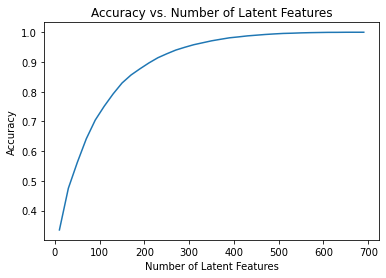

In [161]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [162]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [163]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [164]:
len(user_item_test.index.values)

682

In [165]:
len(user_item_train.index.values)

4487

In [166]:
users_in_both = np.intersect1d(user_item_test.index.values, user_item_train.index.values, assume_unique=True)

In [167]:
len(users_in_both)

20

In [168]:
articles_in_both = np.intersect1d(df_test.article_id.unique(), df_train.article_id.unique(), assume_unique=True)

In [169]:
len(articles_in_both)

574

In [170]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [171]:
# Perform SVD on the User-Item Matrix Here

u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [172]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [173]:
num_latent_feats = np.arange(10,700+10,20)
test_sum_errs = []
train_sum_errs = []


common_idx = user_item_train.index.isin(test_idx)
col_arts = user_item_train.columns.isin(test_arts)

u_test = u_train[common_idx, :]
vt_test = vt_train[:, col_arts]


# test users that we can predict for
common_users = np.intersect1d(list(user_item_train.index),list(user_item_test.index))

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test.loc[common_users,:], user_item_test_preds)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    train_sum_errs.append(err_train)
    test_sum_errs.append(err_test)
    


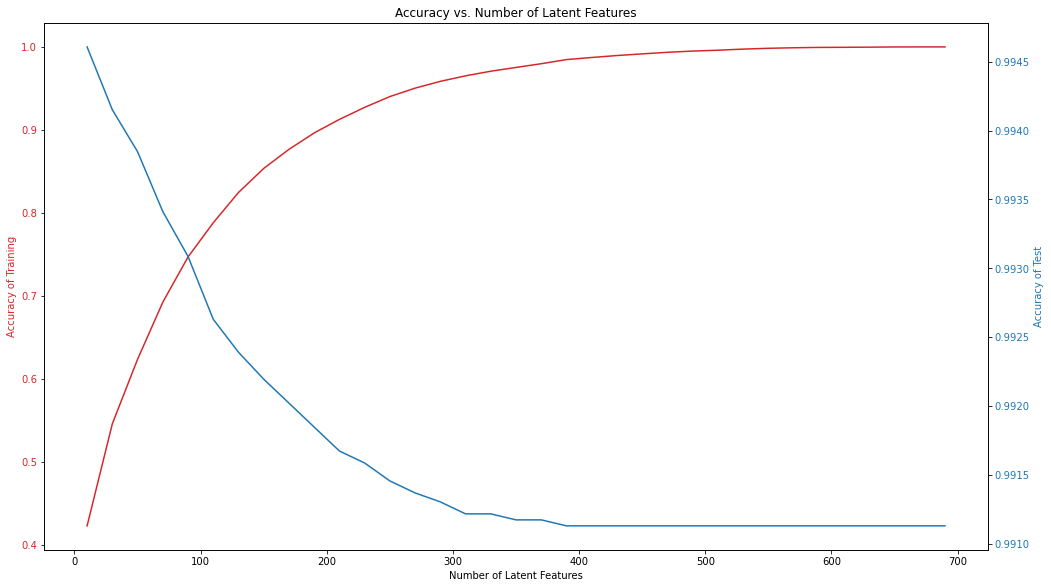

In [174]:
# plotting the training and test accuracies
fig, ax1 = plt.subplots(figsize=[14.70, 8.27])

color = 'tab:red'
ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('Accuracy of Training', color=color)
ax1.plot(num_latent_feats, 1 - np.array(train_sum_errs)/df.shape[0], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Accuracy vs. Number of Latent Features')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy of Test', color=color)  # we already handled the x-label with ax1
ax2.plot(num_latent_feats, 1 - np.array(test_sum_errs)/df.shape[0], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

The plot shows that increasing the number of latent features improves the accuracy of training data significantly but decreases the accuracy of test data. When the number of latent features becomes too high (after 400 features approxemetely), the accuracy of training data stops improving.  

The plot also shows when the number of features is below 100, the accuracy of testing is higher than training. After 100 features, the accuracy of training is getting higher than testing, indicating some level of overfitting in the model.

To determine if the recommendations generated by the recommendation system are an improvement over how users currently find articles, we could run AB testing, where we randomly split users into two groups. The first group will receive recommendations generated by the recommendation system, while the other group will not. By comparing the measure such as the number of articles read of both groups we can determine if the improvement from recommendations systems is statistically significant. 

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [175]:
#from subprocess import call
#call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])